<a href="https://colab.research.google.com/github/SVGS-EVA4/Phase2/blob/master/S2-MobileNets_and_ShuffleNets/Extras/Sushmitha/Mobilenet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-w4u03z8e
Albumentation library is successfully installed!


In [3]:
!git clone https://github.com/Sushmitha-Katti/PyTNet

Cloning into 'PyTNet'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 153 (delta 82), reused 102 (delta 40), pack-reused 0
Receiving objects: 100% (153/153), 40.03 KiB | 2.67 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [4]:
import sys
sys.path.append("PyTNet")

In [5]:
import torch
import train_test_loader
import show_images
import Training.train_test
import evaluate
from Albumentationtransform import AlbumentationTransforms
from GradCam import GradCAM,visualize_cam
from LR_Range_Test import LR_test

In [6]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/EV4P2/session2/dataset.zip","r") as zip_ref:
    zip_ref.extractall()

In [7]:
"""tinyimagenet.py

"""

from torch.utils.data import Dataset, random_split
from PIL import Image
import numpy as np
import torch
import os
import torchvision.transforms as transforms
from tqdm import notebook
import zipfile


"""
This is used to download the tiny imagenet data set, load them, split to train test , convert to data set format
TinyImageNetDataSet - This is the main function which calls all all other. 
Parameters :
train_split : The percent of train data. Default it is 70%
test_transforms :Transformations to apply for test data
train_transforms : Transformations to apply for train data
Return Value : train_set, test_set of type dataset. Which are ready to go in Dataloader
Description of How it is implemented : 
TinyImageNetDataSet is the function which intern calls many funtions
1. Download_images - It dowloads the images from the given url and exact the zip file.
2. class_names - Derives the classes of tiny- Imagenet.
3. TinyImageNet - This returns the complete data of type data set.
4. Then we split the data we got from TinyImageNet class into train and test.
5. DatasetFromSubset - takes train or test data set and apply given transformations  
Finaly trainset, testset are returned.
"""



# -----------------------------------------------------Main Function which calls everything--------------------------------------------------------------
def TinyImageNetDataSet(train_split = 70,test_transforms = None,train_transforms = None, path = "/content/dataset/"):




  dataset = TinyImageNet(path)
  train_len = len(dataset)*train_split//100
  test_len = len(dataset) - train_len 
  train_set, val_set = random_split(dataset, [train_len, test_len])
  train_dataset = DatasetFromSubset(train_set, transform=train_transforms)
  test_dataset = DatasetFromSubset(val_set, transform=test_transforms)

  return train_dataset, test_dataset



# --------------------------------------------------------------Custom data set-------------------------------------------------------------------------

class TinyImageNet(Dataset):
    def __init__(self,path ='/content/dataset/' ):
        self.data = []
        self.target = []
        self.classes = {'Flying_Birds' : 0,  'Large_QuadCopters' : 1 , 'Small_QuadCopters' : 2 , 'Winged_Drones' : 3}
        for classs in self.classes : 
          full_path = path + classs
          for filename in os.listdir(full_path):
            self.data.append(full_path+"/"+filename)
            self.target.append(self.classes[classs])
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        target = self.target[idx]
        img = data     
        return data,target



# ----------------------------------------------------Data subset which comes after splitting--------------------------------------------------

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
       
        x = Image.open(x).convert('RGB')
      
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# -------------------------------------------------------------------------------------------------------------------------------------------------------



In [9]:
import albumentations as A
import cv2
channel_means =  (0.53105756, 0.58601165, 0.61593276)
channel_stdevs = (0.28278487, 0.25762487 ,0.29407342)
train_transform = AlbumentationTransforms([       
                                                                
                                      A.HorizontalFlip(p = 0.7),
                                      A.PadIfNeeded(min_height=500, min_width=500, border_mode=4, value=None, mask_value=None, always_apply=False, p=1.0),
                                      A.RandomCrop(224, 224, always_apply=False, p=1.0),
                                      A.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=32,max_w_size = 32,p=0.7) 
                                       ])
test_transform = AlbumentationTransforms([
                                          A.Normalize(mean=channel_means, std=channel_stdevs),
                                          
                                          A.Resize(224,224),
                                          
                                        ])
train_dataset , test_dataset = TinyImageNetDataSet(train_split = 70,test_transforms = test_transform,train_transforms = train_transform)

In [10]:
trainloader, testloader = train_test_loader.load(train_dataset,test_dataset,batch_size=128)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


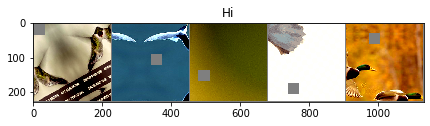

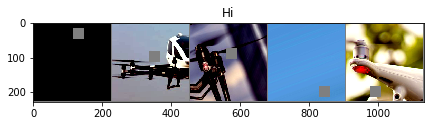

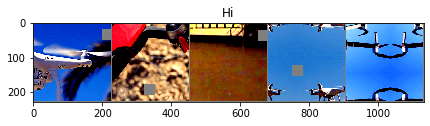

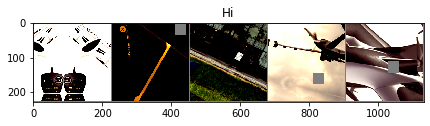

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

classes = {'Flying_Birds' : 0,  'Large_QuadCopters' : 1 , 'Small_QuadCopters' : 2 , 'Winged_Drones' : 3}
# functions to show an image
def imshow_images(img,c = "Hi"):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(7,7))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)



def show_train_data(dataset):

	# get some random training images

  dataiter = iter(dataset)
  images, labels = dataiter.next()
  for i in range(4):
    index = [j for j in range(len(labels)) if labels[j] == i]
    imshow_images(torchvision.utils.make_grid(images[index[0:5]],nrow=5,padding=2,scale_each=True), )

show_train_data(trainloader)

In [12]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [13]:
import torch.nn as nn
model.classifier[1] = nn.Linear(1280, 4 ,False)

In [14]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model.to('cuda')
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [15]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
criterion = nn.CrossEntropyLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.002, total_steps=None, epochs=3, steps_per_epoch=len(trainloader), pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =10)

In [16]:
Training.train_test.train_model(model,device,trainloader,testloader,optimizer,criterion,3,scheduler,batch_scheduler=False,best_acc = 0,path = "newtinymodel.pt")

EPOCH: 1 LR: 0.0002


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expe

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "




Test set: Average loss: 0.0053, Accuracy: 4882/6401 (76.27%)

accuracy increased, Saving model....
EPOCH: 2 LR: 0.00021551724137931034


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "




Test set: Average loss: 0.0045, Accuracy: 5033/6401 (78.63%)

accuracy increased, Saving model....
EPOCH: 3 LR: 0.0002310344827586207


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "




Test set: Average loss: 0.0042, Accuracy: 5123/6401 (80.03%)

accuracy increased, Saving model....
